---
layout: page
title: Inflation
---

In [1]:
import sys
sys.path.insert(0, '../src')
import os
import pandas as pd
from numpy import quantile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from data_loader import load_data, get_last_publish_date

The Consumer Price Index that the Reserve Bank of Australia use to index inflation is published quarterly, one month after the end of each quarter.

In [2]:
"""
RBA Inflation Rate (Consumer Price Index) is released quarterly, 
and the monthly CPI 'indicator' that includes 2/3rds of the CPI basket is released monthly.
Q3 2023 was published Thu 26 Oct 2023. Q4 should be expected Thu 25 Jan 2024 but not published on 25 or 26 (public holiday).
"""
# RBA quarterly inflation rates from 1922
# Rates are published in the month after the quarter ends.
# E.g. the rate for 2024Q1 Jan to March is published end of April 2024.
publish_date = get_last_publish_date()
publish_date_days_ago = (pd.Timestamp.now() - publish_date).days

csv_url = 'https://www.rba.gov.au/statistics/tables/csv/g1-data.csv'
local_file = '../data/g1-data.csv'
max_age_days = publish_date_days_ago

# First 10 rows are descriptive header rows
skip_rows = 10

df_inflation = load_data(csv_url, local_file, max_age_days, skip_rows)

In [3]:
""" Data Transformation """
# GCPIAGYP = Consumer Price Index: All Groups, Percentage change from corresponding quarter of previous year

# Series ID dates are in the format 'Jan-1959' %b-%Y
df_inflation['Date'] = df_inflation['Series ID'].apply(lambda d: pd.to_datetime(d, format='%b-%Y') + pd.offsets.MonthEnd(1))
df_inflation.set_index('Date', inplace=True)

last_index = df_inflation['GCPIAGYP'].last_valid_index()
# only include rows up to the last_index (drop the NaN rows at end of file)
df_inflation = df_inflation.loc[:last_index]

In [4]:
""" Chart variables """
start_year = 1960

# Set 'last_quarter' to the last quarter with a valid value for GCPIAGYP (so I can display 'as of <date>' in chart title)
last_quarter = pd.Period(last_index, freq='Q')

Inflation rocketed through the roof in the 1970s peaking at 18% in 1975. 

Inflation remained highly volatile but eventually stabilized through the 1990s, then trends slightly down until the sharp rise in 2021.

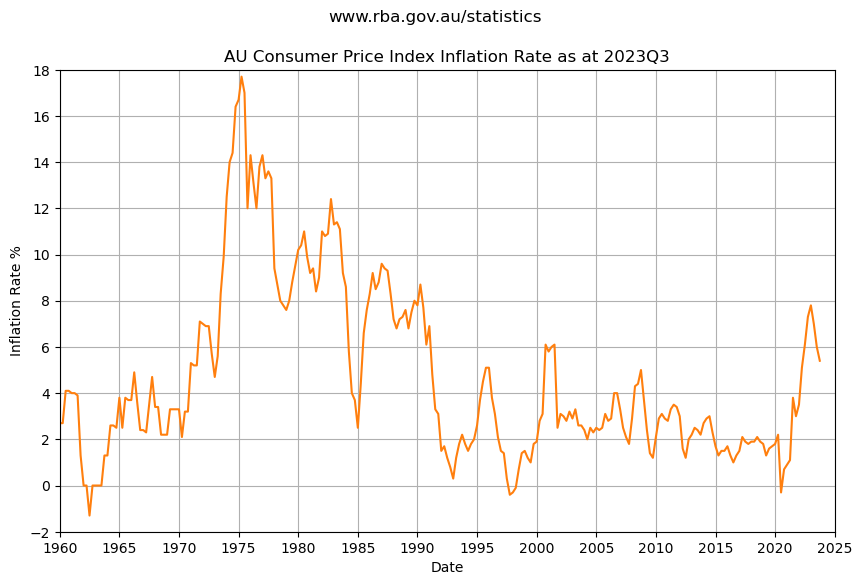

In [5]:
# Basic chart
colors = list(plt.rcParams['axes.prop_cycle'])

plt.figure(figsize=(10, 6))
plt.plot(df_inflation.index, df_inflation['GCPIAGYP'], color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('Inflation Rate %')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Consumer Price Index Inflation Rate as at ' + str(last_quarter))

left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 1960:
    top_limit = 18
    bottom_limit = -2
    tick_years = 5
else:
    top_limit = 26
    bottom_limit = -14
    tick_years = 10
plt.ylim(bottom=bottom_limit, top=top_limit) 
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

plt.grid(True)
plt.show()

Calculating the 25th and 75th percentile over multi-year time horizon helps visualize long term trends.

In [6]:
quantile_lower = 0.25
quantile_median = 0.5
quantile_upper = 0.75
multi_year = 10
multi_year_extended = 3
periods_per_year = 4

YoY = df_inflation['GCPIAGYP']
# Calculate the lower and upper percentile over the previous 1 year
df_inflation['YoY_lower'] = YoY.rolling(window=periods_per_year).quantile(quantile_lower)
df_inflation['YoY_median'] = YoY.rolling(window=periods_per_year).quantile(quantile_median)
df_inflation['YoY_upper'] = YoY.rolling(window=periods_per_year).quantile(quantile_upper)

# Add multi-year 
df_inflation['MY_lower'] = YoY.rolling(window=(periods_per_year*multi_year)).quantile(quantile_lower)
df_inflation['MY_median'] = YoY.rolling(window=(periods_per_year*multi_year)).quantile(quantile_median)
df_inflation['MY_upper'] = YoY.rolling(window=(periods_per_year*multi_year)).quantile(quantile_upper)

# Add multi-year 
df_inflation['MYX_lower'] =  YoY.rolling(window=(periods_per_year*multi_year*multi_year_extended)).quantile(quantile_lower)
df_inflation['MYX_median'] = YoY.rolling(window=(periods_per_year*multi_year*multi_year_extended)).quantile(quantile_median)
df_inflation['MYX_upper'] =  YoY.rolling(window=(periods_per_year*multi_year*multi_year_extended)).quantile(quantile_upper)

# Markdown variables
lower_percentile_YoY_change =  df_inflation['MY_lower'].iloc[-1].round(2)
median_percentile_YoY_change = df_inflation['MY_median'].iloc[-1].round(2)
upper_percentile_YoY_change =  df_inflation['MY_upper'].iloc[-1].round(2)
lower_percentile_MYX_change =  df_inflation['MYX_lower'].iloc[-1].round(2)
median_percentile_MYX_change = df_inflation['MYX_median'].iloc[-1].round(2)
upper_percentile_MYX_change =  df_inflation['MYX_upper'].iloc[-1].round(2)

from IPython.display import display, Markdown
display(Markdown(f"""
Over the last {multi_year} years the median change is {median_percentile_YoY_change}%:
- 25th percentile YoY change is {lower_percentile_YoY_change}%
- 50th percentile YoY change is {median_percentile_YoY_change}%
- 75th percentile YoY change is {upper_percentile_YoY_change}%

Over the last {multi_year*multi_year_extended} years:
- 25th percentile YoY change is {lower_percentile_MYX_change}%
- 50th percentile YoY change is {median_percentile_MYX_change}%
- 75th percentile YoY change is {upper_percentile_MYX_change}%
"""))


Over the last 10 years the median change is 1.9%:
- 25th percentile YoY change is 1.5%
- 50th percentile YoY change is 1.9%
- 75th percentile YoY change is 3.0%

Over the last 30 years:
- 25th percentile YoY change is 1.7%
- 50th percentile YoY change is 2.4%
- 75th percentile YoY change is 3.12%


The chart shows inflation stayed close to the RBA target inflation rate of 2 to 3 percent for over twenty five years.

> ℹ The data suggests reasonable confidence using a baseline inflation of 2% to 2.5% with some uncertainty or risk that inflation could peak higher.

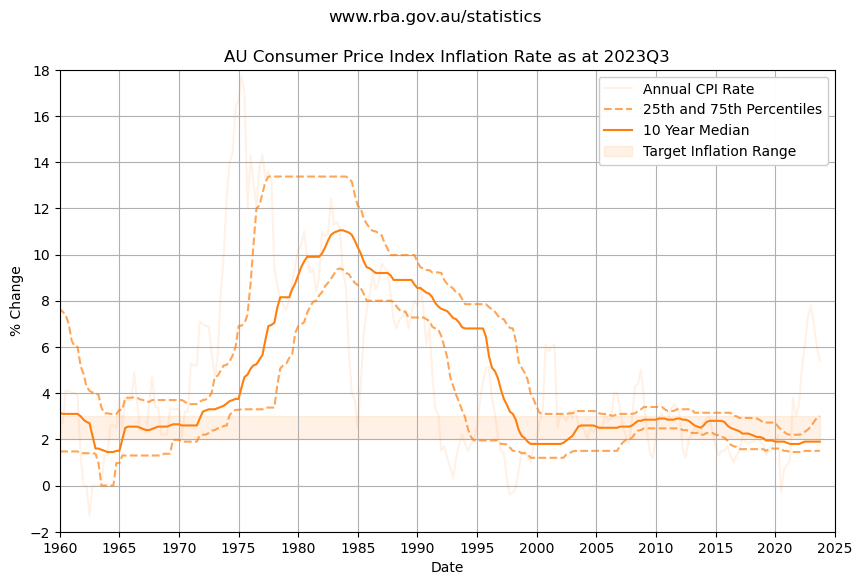

In [7]:
"""
Chart should be similar to the 'official' CPI chart
https://www.rba.gov.au/inflation/measures-cpi.html
"""
# Rolling average chart
plt.figure(figsize=(10, 6))
plt.plot(df_inflation.index, df_inflation['GCPIAGYP'], label='Annual CPI Rate', color=colors[1]['color'], alpha=0.1)
quantile_label = str(int(quantile_lower*100)) + 'th and ' + str(int(quantile_upper*100)) + 'th Percentiles'
plt.plot(df_inflation.index, df_inflation['MY_lower'], color=colors[1]['color'], linestyle='--', alpha=0.7, label=quantile_label)
plt.plot(df_inflation.index, df_inflation['MY_median'], color=colors[1]['color'], label=str(multi_year) + ' Year Median')
plt.plot(df_inflation.index, df_inflation['MY_upper'], color=colors[1]['color'], linestyle='--', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('% Change')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Consumer Price Index Inflation Rate as at ' + str(last_quarter))
plt.ylim(bottom=bottom_limit, top=top_limit) 
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

plt.grid(True)

# Add a horizontal band between y=2 and y=3
plt.fill_between(df_inflation.index, 2, 3, color=colors[1]['color'], alpha=0.1)
# Create a Patch for the legend
target_range = mpatches.Patch(color=colors[1]['color'], alpha=0.1, label='Target Inflation Range')
# Get the existing legend entries
handles, labels = ax.get_legend_handles_labels()
# Add the patch to the existing handles
handles.append(target_range)
# Create the legend with the existing entries and the new patch
legend = plt.legend(handles=handles, loc='best')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()

In [10]:
%%capture
# Magic store dataframe to share with combo notebook
%store df_inflation